In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
image_list = ['00125v.jpg', '00153v.jpg', '00398v.jpg', '00149v.jpg', '00351v.jpg', '01112v.jpg']
for i in range(len(image_list)):
    image_list[i] = 'mp0-data/prokudin-gorskii/' + image_list[i]
filename = image_list[5]
img = mpimg.imread(filename)
input_image = img / np.max(img)
height, width = input_image.shape
print(height)

1024


# Problem (a) Combine
In this problem, we are asked to choose one of the images and divide the image into three equal parts. Then we save the image with BGR channels.

In [3]:
height = int(height/3)
image_a = np.zeros((height, width, 3))
# fill the image for part a by RGB order
# input image is ordered as BGR
R = input_image[2*height:3*height, :]
G = input_image[1*height:2*height, :]
B = input_image[0*height:1*height, :]
image_a[:, :, 0] = R
image_a[:, :, 1] = G
image_a[:, :, 2] = B

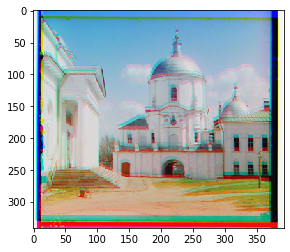

In [4]:
plt.imshow(image_a)
# save the image_a for report
mpimg.imsave('image_a.png', image_a)

# Problem (b) Align
In this part, we are required to find a best offset for two channels while keeping one channel as the reference to get a best alignment.

There are two similarity mertric that I use here. First is the (negative) sum of squared differences (SSD) and second is the zero mean normalized cross correlation (zncc).

In [18]:
def offset(c1, c2, method, r=15):
    # In this function, we have two different input channels c1 and c2.
    # Our goal is to find a offset (x, y) (-15 <= x,y <= 15) of channel c2 such that
    # two channels have the largest value in metric
    # if two channels are aligned well, their similarity will be large
    # if method=0, using (negative) sum of square differences as the metric
    # if method=1, using zero mean normarlized cross correlation as the metric
    # assume that c1 and c2 have the same size
    off_x, off_y = 0, 0
    max_metric = -float("inf")
    for i in range(-r, r+1):
        for j in range(-r, r+1):
            # first pad the channels with 0 to have the same size
            # ch1 = np.pad(c1, ((max(0, -i), max(0, i)), (max(0, -j), max(0, j))), 'constant')
            # ch2 = np.pad(c2, ((max(0, i), max(0, -i)), (max(0, j), max(0, -j))), 'constant')
            ch1 = c1
            ch2 = np.roll(c2, i, axis=0)
            ch2 = np.roll(ch2, j, axis=1)
            if method=='ssd':
                # perform the difference
                diff = - np.sum((ch1-ch2)**2)
                # print(diff, i, j)
                if (diff > max_metric):
                    max_metric = diff
                    off_x = i
                    off_y = j
            else:
                zncc = get_zncc(ch1, ch2)
                if (zncc > max_metric):
                    max_metric = zncc
                    off_x = i
                    off_y = j
    return off_x, off_y

# helper function for Zero Mean Normalized Cross Correlation method
def get_mean(c):
    h, w = c.shape
    return np.sum(c) / (h*w)

def get_mean_std(c):
    mean = get_mean(c)
    h, w = c.shape
    std = np.sum((c-mean)**2)**0.5 / (h*w)
    return mean, std

def get_zncc(c1, c2):
    # we need to calculate the zero mean normalized cross correlation between channel1 and channel2
    mean1, std1 = get_mean_std(c1)
    mean2, std2 = get_mean_std(c2)
    h, w = c1.shape
    return np.sum((c1-mean1)*(c2-mean2)) / (h*w*std1*std2)

In [19]:
def align(input_image, filename, image_name, method_list, fast=False, off=None):
    offset_list = []
    height, width = input_image.shape
    height = int(height/3)
    R = input_image[2*height:3*height, :]
    G = input_image[1*height:2*height, :]
    B = input_image[0*height:1*height, :]
    if fast:
        # if this is the fast alignment, we need to reduce the resolution by half
        R = R[0::2, 0::2]
        G = G[0::2, 0::2]
        B = B[0::2, 0::2]
    if off:
        # for fast align, we need to adjust the RGB channel by previous offset
        off_Gx, off_Gy, off_Bx, off_By = off
        G = np.roll(G, 2*off_Gx, axis=0)
        G = np.roll(G, 2*off_Gy, axis=1)
        B = np.roll(B, 2*off_Bx, axis=0)
        B = np.roll(B, 2*off_By, axis=1)
    # now find the offset using both methods and save the image to file
    for method in method_list:
        # first calculate offset
        off_Gx, off_Gy = offset(R, G, method)
        off_Bx, off_By = offset(R, B, method)
        # second construct new image
        new_R = R
        new_G = np.roll(G, off_Gx, axis=0)
        new_G = np.roll(new_G, off_Gy, axis=1)
        new_B = np.roll(B, off_Bx, axis=0)
        new_B = np.roll(new_B, off_By, axis=1)

        new_height, new_width = new_R.shape
        new_image = np.zeros((new_height, new_width, 3))
        new_image[:, :, 0] = new_R
        new_image[:, :, 1] = new_G
        new_image[:, :, 2] = new_B
        # at last save the new image
        plt.figure()
        plt.imshow(new_image)
        intermid = ' intermediate' if fast else ''
        plt.title('plot '+ filename + ' using ' + method + ' method' + intermid)
        plt.show()
        print('Using Red channel as the base')
        print('Green channel has offsets:', off_Gx, off_Gy)
        print('Blue channel has offsets:', off_Bx, off_By)
        # save the image for report
        new_image_title = method + intermid + '_' + image_name
        mpimg.imsave(new_image_title, new_image)
        # fill the offset list
        # we only fill the offset using the ssd method since two methods give us the same offset
        if method=='ssd':
            offset_list.extend([off_Gx, off_Gy, off_Bx, off_By])
    return offset_list

def question_b(image_list, method_list):
    # in this function, we will test all images in the image_list using both SSD and ZNCC method
    offset_list = []
    for filename in image_list:
        image_name = filename[-10:]
        img = mpimg.imread(filename)
        input_image = img / np.max(img)
        offset_one_image = align(input_image, filename, image_name, method_list)
        offset_list.append(offset_one_image)
    print(offset_list)

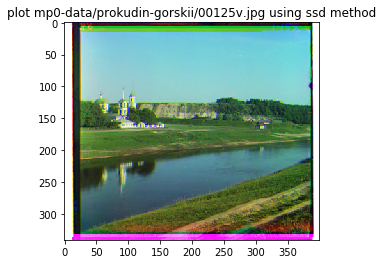

Using Red channel as the base
Green channel has offsets: -4 1
Blue channel has offsets: -10 2


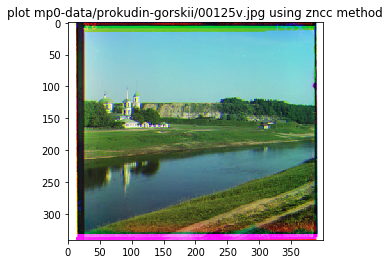

Using Red channel as the base
Green channel has offsets: -4 1
Blue channel has offsets: -10 2


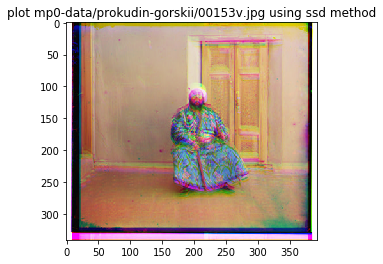

Using Red channel as the base
Green channel has offsets: -13 -2
Blue channel has offsets: -11 -3


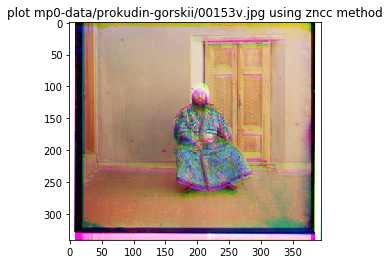

Using Red channel as the base
Green channel has offsets: -13 -2
Blue channel has offsets: -11 -3


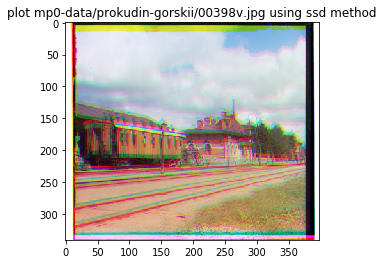

Using Red channel as the base
Green channel has offsets: 0 1
Blue channel has offsets: -8 2


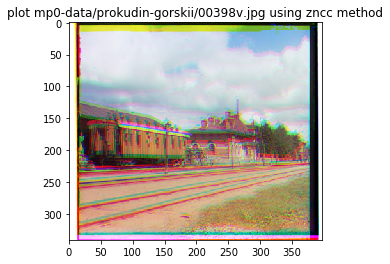

Using Red channel as the base
Green channel has offsets: 0 1
Blue channel has offsets: -8 2


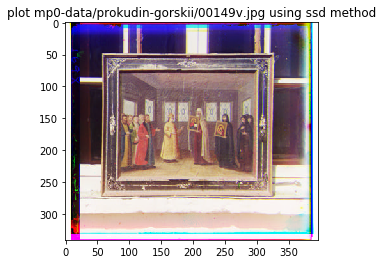

Using Red channel as the base
Green channel has offsets: -5 0
Blue channel has offsets: -9 -1


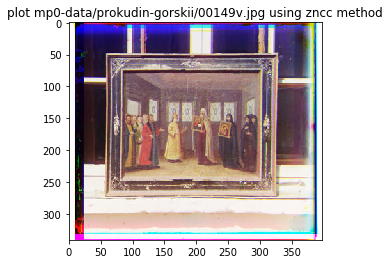

Using Red channel as the base
Green channel has offsets: -5 0
Blue channel has offsets: -9 -1


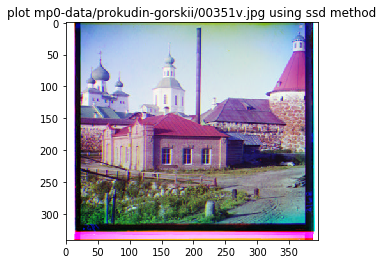

Using Red channel as the base
Green channel has offsets: -9 0
Blue channel has offsets: -13 1


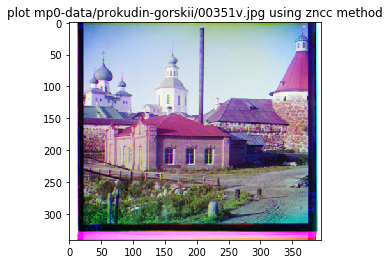

Using Red channel as the base
Green channel has offsets: -9 0
Blue channel has offsets: -13 1


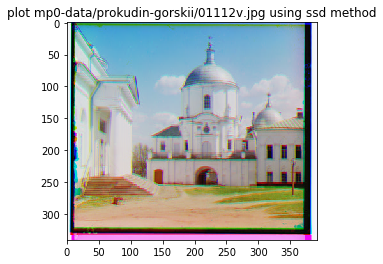

Using Red channel as the base
Green channel has offsets: -8 -1
Blue channel has offsets: -8 -3


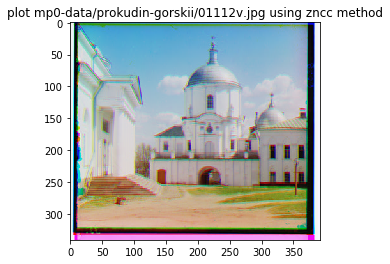

Using Red channel as the base
Green channel has offsets: -8 -1
Blue channel has offsets: -8 -3
[[-4, 1, -10, 2], [-13, -2, -11, -3], [0, 1, -8, 2], [-5, 0, -9, -1], [-9, 0, -13, 1], [-8, -1, -8, -3]]


In [23]:
method_list = ['ssd', 'zncc']
question_b(image_list, method_list)

# Problem (c) Fast Align
In this part, we need to align a large image twice to reduce the computation

In [33]:
fast_image_list = ['seoul_tableau.jpg', 'vancouver_tableau.jpg']
for i in range(len(fast_image_list)):
    fast_image_list[i] = 'mp0-data/' + fast_image_list[i]
def question_c(image_list, method_list):
    # in this function, we will test all images in the image_list using both SSD and ZNCC method
    for filename in image_list:
        image_name = filename[9:]
        img = mpimg.imread(filename)
        input_image = img / np.max(img)
        height, width = input_image.shape
        height = int(height/3)
        R = input_image[2*height:3*height, :]
        G = input_image[1*height:2*height, :]
        B = input_image[0*height:1*height, :]
        image_c = np.zeros((height, width, 3))
        image_c[:, :, 0] = R
        image_c[:, :, 1] = G
        image_c[:, :, 2] = B
        plt.figure()
        plt.imshow(image_c)
        plt.title('Before alignment, ' + filename)
        plt.show()

    for filename in image_list:
        image_name = filename[9:]
        img = mpimg.imread(filename)
        input_image = img / np.max(img)
        offset_first_image = align(input_image, filename, image_name, method_list, fast=True)
        offset_second_image = align(input_image, filename, image_name, method_list, off=offset_first_image)
        total_offset = 2*np.array(offset_first_image) + np.array(offset_second_image)
        print('Combine two alignment, the total offset is:', total_offset)

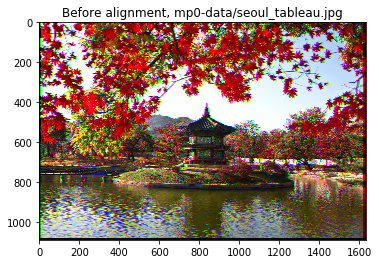

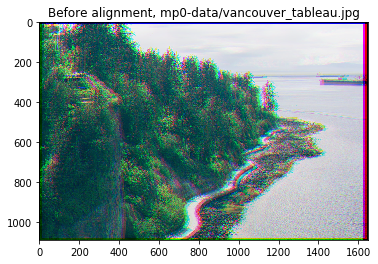

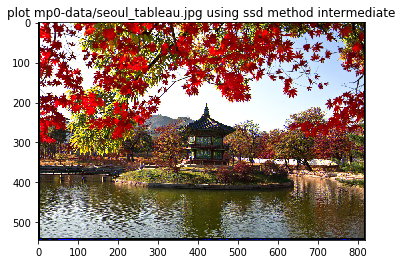

Using Red channel as the base
Green channel has offsets: 0 3
Blue channel has offsets: -1 1


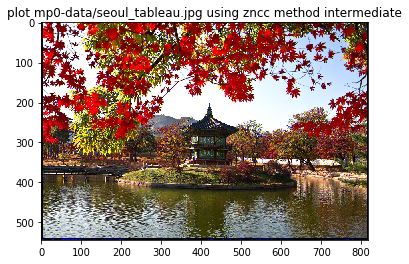

Using Red channel as the base
Green channel has offsets: 0 3
Blue channel has offsets: -1 1


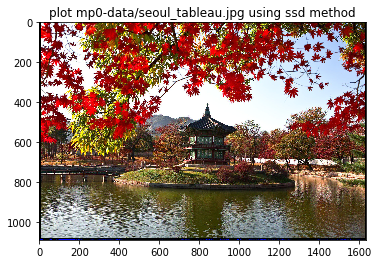

Using Red channel as the base
Green channel has offsets: 0 0
Blue channel has offsets: 0 -1


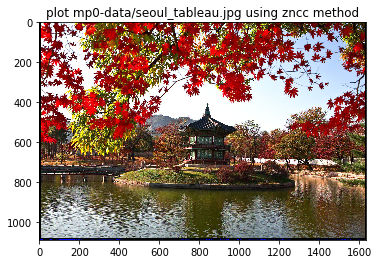

Using Red channel as the base
Green channel has offsets: 0 0
Blue channel has offsets: 0 -1
Combine two alignment, the total offset is: [ 0  6 -2  1]


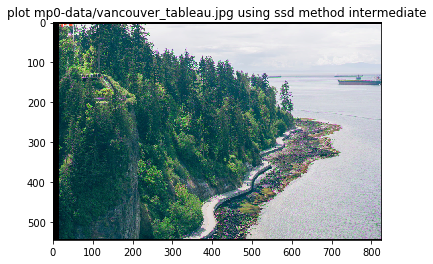

Using Red channel as the base
Green channel has offsets: -1 11
Blue channel has offsets: 4 6


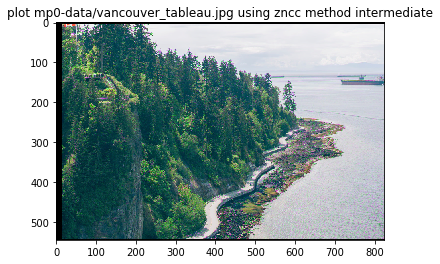

Using Red channel as the base
Green channel has offsets: -1 11
Blue channel has offsets: 4 6


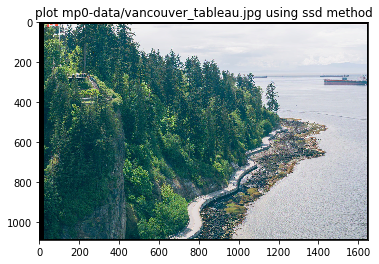

Using Red channel as the base
Green channel has offsets: 1 0
Blue channel has offsets: 0 0


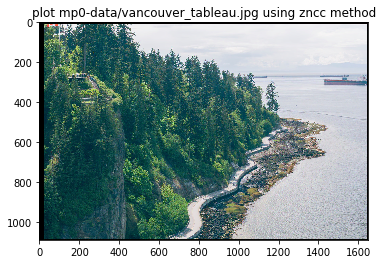

Using Red channel as the base
Green channel has offsets: 1 0
Blue channel has offsets: 0 0
Combine two alignment, the total offset is: [-1 22  8 12]


In [34]:
question_c(fast_image_list, method_list)

# Problem (d) Extra Credit
In this part, I think of some method that can give us a better quality of the alignment. As we can see from the images in part (b), many images still do not align very well. The main reason might be the fact that there is a black frame around the image. The goal for this part is, we need to figure out a method that can efficiently reduce the black frame around the image (or RGB channels) and therefore make the better alignment.

1024


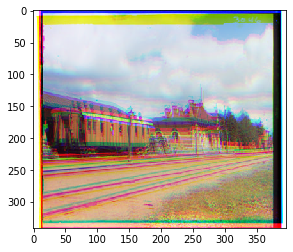

In [3]:
filename = image_list[2]
image_name = filename[-10:]
img = mpimg.imread(filename)
input_image = img / np.max(img)
height, width = input_image.shape
print(height)
height = int(height/3)
image_d = np.zeros((height, width, 3))
# fill the image for part a by RGB order
# input image is ordered as BGR
R = input_image[2*height:3*height, :]
G = input_image[1*height:2*height, :]
B = input_image[0*height:1*height, :]
image_d[:, :, 0] = R
image_d[:, :, 1] = G
image_d[:, :, 2] = B
plt.imshow(image_d)

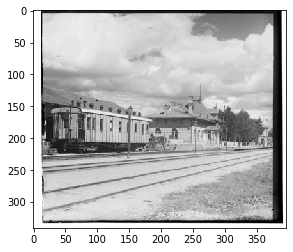

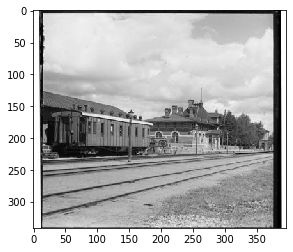

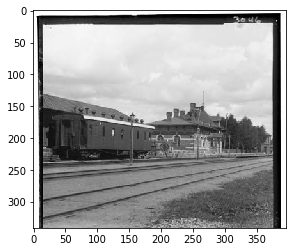

In [4]:
plt.figure()
plt.imshow(R, cmap='gray')
plt.show()
plt.figure()
plt.imshow(G, cmap='gray')
plt.show()
plt.figure()
plt.imshow(B, cmap='gray')
plt.show()

In [5]:
mpimg.imsave('B.png', B)

In [6]:
def crop_image(img, black=0.2, white=0.8, num_tol=0.4):
    # in this function, we simply crop the edges with more than amount of black pixels
    h, w = img.shape
    # we crop the image in vertical direction
    row_start, row_end = 0, h-1
    black_number = (img < black).sum(axis=1)
    white_number = (img > white).sum(axis=1)
    total_meaningless = black_number + white_number
    for i in range(h):
        if total_meaningless[i] > num_tol*w and row_start == i:
            row_start += 1
    for i in range(h-1, -1, -1):
        if total_meaningless[i] > num_tol*w and row_end == i:
            row_end += 1
#     for i in range(h):
#         if black_number[i] > num_tol*w and row_start == i:
#             row_start += 1
#         elif white_number[i] > num_tol*w and row_start == i:
#             row_start += 1
#     for i in range(h-1, -1, -1):
#         if black_number[i] > num_tol*w and row_end == i:
#             row_end -= 1
#         elif white_number[i] > num_tol*w and row_end == i:
#             row_end -= i
    # we do the same thing to the horizontal direction
    col_start, col_end = 0, w-1
    black_number = (img < black).sum(axis=0)
    white_number = (img > white).sum(axis=0)
    total_meaningless = black_number + white_number
    for i in range(w):
        if total_meaningless[i] > num_tol*h and col_start == i:
            col_start += 1
    for i in range(w-1, -1, -1):
        if total_meaningless[i] > num_tol*h and col_end == i:
            col_end -= 1
#     for i in range(w):
#         if black_number[i] > num_tol*h and col_start == i:
#             col_start += 1
#         elif white_number[i] > num_tol*h and col_start == i:
#             col_start += 1
#     for i in range(w-1, -1, -1):
#         if black_number[i] > num_tol*h and col_end == i:
#             col_end -= 1
#         elif white_number[i] > num_tol*h and col_end == i:
#             col_end -= 1
    return img[row_start:row_end+1, col_start:col_end+1]
R_crop = crop_image(R)
G_crop = crop_image(G)
B_crop = crop_image(B)

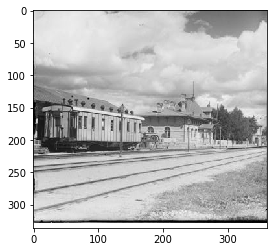

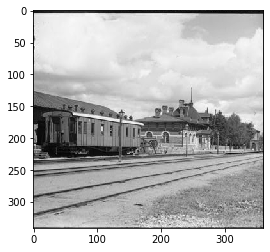

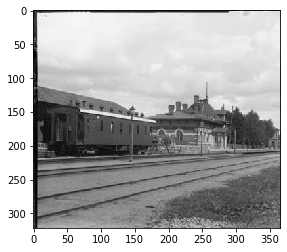

In [7]:
plt.figure()
plt.imshow(R_crop, cmap='gray')
plt.show()
plt.figure()
plt.imshow(G_crop, cmap='gray')
plt.show()
plt.figure()
plt.imshow(B_crop, cmap='gray')
plt.show()

In [13]:
# now we need to find the smallest channel and align all channels together
h_small = min(R_crop.shape[0], G_crop.shape[0], B_crop.shape[0])
w_small = min(R_crop.shape[1], G_crop.shape[1], B_crop.shape[1])
# we need to make every channel have the same size
def crop_image2(img, shape):
    h, w = img.shape
    h0, w0 = shape
    h_start, h_end = int(h/2-h0/2), int(h/2-h0/2)+h0
    w_start, w_end = int(w/2-w0/2), int(w/2-w0/2)+w0
    return img[h_start:h_end, w_start:w_end]
R_c = crop_image2(R_crop, (h_small, w_small))
G_c = crop_image2(G_crop, (h_small, w_small))
B_c = crop_image2(B_crop, (h_small, w_small))

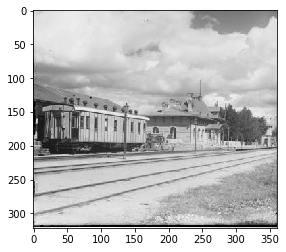

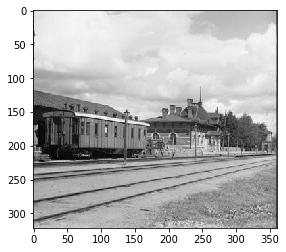

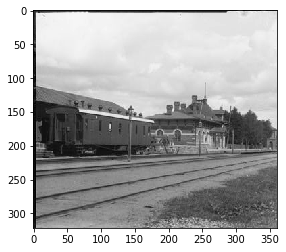

In [15]:
plt.figure()
plt.imshow(R_c, cmap='gray')
plt.show()
plt.figure()
plt.imshow(G_c, cmap='gray')
plt.show()
plt.figure()
plt.imshow(B_c, cmap='gray')
plt.show()

In [16]:
image_ec = np.zeros((h_small, w_small, 3))
image_ec[:, :, 0] = R_c
image_ec[:, :, 1] = G_c
image_ec[:, :, 2] = B_c

In [21]:
method_list = ['ssd', 'zncc']
align(image_ec, 'ec', 'ec', method_list)

ValueError: too many values to unpack (expected 2)

In [182]:
R_crop = crop_image(R)
G_crop = crop_image(G)
B_crop = crop_image(B)
min_shape = (min(R_crop.shape[0], G_crop.shape[0], B_crop.shape[0]),
             min(R_crop.shape[1], G_crop.shape[1], B_crop.shape[1]))
height, width = min_shape
def shrink_channel(c, shape):
    h, w = c.shape
    return c[h-shape[0]:, w-shape[1]:]
new_R = shrink_channel(R_crop, min_shape)
new_G = shrink_channel(G_crop, min_shape)
new_B = shrink_channel(B_crop, min_shape)
image_d = np.vstack([new_B, new_G, new_R])

In [183]:
print(image_d.shape)

(996, 381)


In [184]:
def question_d(input_image, method_list):
    # in this function, we will test all images in the image_list using both SSD and ZNCC method
    offset_one_image = align(input_image, filename, image_name, method_list)
    print(offset_one_image)

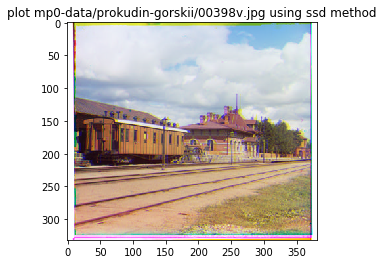

Using Red channel as the base
Green channel has offsets: -3 0
Blue channel has offsets: -8 2
[-3, 0, -8, 2]


In [187]:
question_d(image_d, method_list)

In [188]:
print(method_list)

['ssd', 'zncc']


In [11]:
a.extend((4, 5, 6))

In [12]:
print(a)

[1, 2, 3, 4, 5, 6]


In [22]:
f = False

a = '1'
b = a  + intermid
print(b)

1intermediate


In [20]:
print(intermid)

In [28]:
def func(a, b=None):
    if b:
        print(a)
    else:
        print(a+1)

In [29]:
a = [1, 2, 3, 4]
print(a+a)
a1, a2, a3, a4 = a
print(a1, a2, a3, a4)

[1, 2, 3, 4, 1, 2, 3, 4]
1 2 3 4


In [51]:
b = None
if b:
    print(True)
    print(b)

In [21]:
a = [1, 2, 3, 4]
a1, a2, _ = a

ValueError: too many values to unpack (expected 3)

In [62]:
a = [1, 2, 3]
if (a[0] > 0.9*1):
    print('1')

1


In [74]:
for i in range(1, 10):
    print(i)

1
2
3
4
5
6
7
8
9
